In [2]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import math
import itertools
import random
import pickle
import numpy as np
import gc
import matplotlib.pyplot as pp
import matplotlib.style as style
import pandas as pd
style.use('ggplot')
tf.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
# Choose Dataset
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [0]:
# Split Dataset into Test and Train
test_dataset = dataset['test']
train_dataset = dataset['train']

In [0]:
# Scale pixel values from 0-1
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

In [0]:
# Get # records in test & train sets
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

In [5]:
# Set testing parameters
params = [[tf.nn.relu,tf.nn.leaky_relu], # Convolutional layer activation
          [tf.nn.relu,tf.nn.leaky_relu], # Hidden dense layer activation
          [100,1000], # Hidden dense layer nodes
          [50,500], # Convolutional layer channels
          [3,9], # Convolutional layer kernel size
          [2,6], # Max pooling layer pool size
          [2,6], # Max pooling layer stride length
          ['lr=0.001)','lr=0.01)'], # Learning rate
          ['same','valid'], # Convolutional layer padding
          ['tf.keras.optimizers.Adam(','tf.keras.optimizers.RMSprop('], # Optimization function
          [10,100], # Batch size
          [5,10] # Epochs
         ]

In [0]:
# Define model function
# TODO: If genome already tested, return stored fitness
def get_fitness(genome,train_dataset=train_dataset,test_dataset=test_dataset):
  i = 0
  convact = params[i][genome[i]]
  i += 1
  denseact = params[i][genome[i]]
  i += 1
  densenodes = params[i][genome[i]]
  i += 1
  convchannels = params[i][genome[i]]
  i += 1
  kernsize = params[i][genome[i]]
  i += 1
  poolsize = params[i][genome[i]]
  i += 1
  stridelen = params[i][genome[i]]
  i += 1
  learnrate = params[i][genome[i]]
  i += 1
  padding = params[i][genome[i]]
  i += 1
  optimizer = params[i][genome[i]]
  i += 1
  batchsize = params[i][genome[i]]
  i += 1
  epochs = params[i][genome[i]]
  
  train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(batchsize)
  test_dataset = test_dataset.batch(batchsize)
  
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(convchannels, (kernsize,kernsize), padding=padding, activation=convact, input_shape=metadata.features['image'].shape),
    tf.keras.layers.MaxPooling2D((poolsize, poolsize), strides=stridelen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(densenodes, activation=denseact),
    tf.keras.layers.Dense(metadata.features['label'].num_classes,  activation=tf.nn.softmax)
    ])
  
  optimizer = eval(optimizer + learnrate)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  history = model.fit(train_dataset, epochs=epochs, steps_per_epoch=math.ceil(num_train_examples/batchsize), verbose=0)
  
  results = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/batchsize))
  
  del model
  tf.reset_default_graph()
  tf.keras.backend.clear_session()
  gc.collect()
  
  return results[1], history.history['acc']

In [0]:
# Create list of all possible hyperparameter value combinations
allgenomes = [list(i) for i in itertools.product([0, 1], repeat=len(params))]
print('Possible combinations: ' + str(len(allgenomes)))

Possible combinations: 4096


In [0]:
%%time
# Test and evolve population. Derive mating pool using fitness tiers.
suffix = 'tier5gen'
population = [allgenomes[i] for i in random.sample(range(0,len(allgenomes)),20)]
populations = []
fitnesses_test = []
fitnesses_train = []
for j in range(5):
  print('EVALUATING GENERATION: ' + str(j+1))
  populations.append(population)
  fitness_test = []
  fitness_train = []
  for x in population:
    fitness_test_g, fitness_train_g = get_fitness(x)
    fitness_test.append(fitness_test_g)
    fitness_train.append(fitness_train_g)
  fitnesses_test.append(fitness_test)
  fitnesses_train.append(fitness_train)
  tier1 = [population[i] for i in sorted(range(len(fitness_test)), key=lambda i: fitness_test[i])[-5:]]
  tier2 = [population[i] for i in sorted(range(len(fitness_test)), key=lambda i: fitness_test[i])[-10:-5]]
  tier3 = [population[i] for i in sorted(range(len(fitness_test)), key=lambda i: fitness_test[i])[-15:-10]]
  elite = tier1 + tier2
  breeders = tier1 + tier3
  random.shuffle(elite)
  random.shuffle(breeders)
  children = []
  mutants = []
  for i in range(0,5):
    split = random.randint(0,10)
    child = elite[i][:split] + elite[-(i+1)][split:]
    children.append(child)
    mutant = child.copy()
    mutate = random.randint(0,10)
    if mutant[mutate] == 0:
      mutant[mutate] = 1
    else:
      mutant[mutate] = 0
    mutants.append(mutant)
    split = random.randint(0,10)
    child = breeders[i][:split] + breeders[-(i+1)][split:]
    children.append(child)
    mutant = child.copy()
    mutate = random.randint(0,10)
    if mutant[mutate] == 0:
      mutant[mutate] = 1
    else:
      mutant[mutate] = 0
    mutants.append(mutant)
  population = children + mutants

EVALUATING GENERATION: 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1000/1000 [==============================] - 8s 8ms/step - loss: 14.5063 - acc: 0.1000
EVALUATING GENERATION: 2
1000/1000 [==============================] - 6s 6ms/step - loss: 14.5063 - acc: 0.1000
EVALUATING GENERATION: 3
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3366 - acc: 0.8861
EVALUATING GENERATION: 4
100/100 [==============================] - 3s 27ms/step - loss: 0.3511 - acc: 0.8755
EVALUATING GENERATION: 5
100/100 [==============================] - 3s 27ms/step - loss: 0.3230 - acc: 0.8828
CPU times: user 11h 22min 7s, sys: 3h 19min 41s, total: 14h 41min 49s
Wall time: 10h 59min 39s


In [0]:
%%time
# Test and evolve population. Derive mating pool using SRSWR and fitness-based probability
suffix = 'prob20gen'
population = [allgenomes[i] for i in random.sample(range(0,len(allgenomes)),5)]
mutationrate = 0.01
alleles = len(population) * len(params)
mutations = math.ceil(alleles * mutationrate)
populations = []
fitnesses_test = []
fitnesses_train = []
for j in range(0,20):
  print('EVALUATING GENERATION: ' + str(j+1))
  populations.append(population)
  fitness_test = []
  fitness_train = []
  for x in population:
    fitness_test_g, fitness_train_g = get_fitness(x)
    fitness_test.append(fitness_test_g)
    fitness_train.append(fitness_train_g)
  fitnesses_test.append(fitness_test)
  fitnesses_train.append(fitness_train)
  matingpool = [population[x] for x in np.random.choice(len(population), len(population), p = (fitness_test / sum(fitness_test)))]
  children = []
  for i in range(len(population)):
    split = random.randint(0,len(params))
    child = population[i][:split] + matingpool[i][split:]
    children.append(child)
  mutategenome = np.random.choice(len(population),mutations)
  mutateallele = np.random.choice(len(params),mutations)
  for i in range(mutations):
    if children[mutategenome[i]][mutateallele[i]] == 0:
      children[mutategenome[i]][mutateallele[i]] = 1
    else:
      children[mutategenome[i]][mutateallele[i]] = 0
  population = children

EVALUATING GENERATION: 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1000/1000 [==============================] - 5s 5ms/step - loss: 0.3245 - acc: 0.8949
EVALUATING GENERATION: 2
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3488 - acc: 0.9020
EVALUATING GENERATION: 3
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3694 - acc: 0.8915
EVALUATING GENERATION: 4
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3433 - acc: 0.9052
EVALUATING GENERATION: 5
100/100 [==============================] - 3s 26ms/step - loss: 0.3149 - acc: 0.8858
EVALUATING GENERATION: 6
100/100 [==============================] - 3s 27ms/step - loss: 0.3065 - acc: 0.8960
EVALUATING GENERATION: 7
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2956 - acc: 0.9115
EVALUATING GENERATION: 8
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3279 - acc: 0.9064
EVALUATING GENERATION: 9
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3707 - acc: 0.9029
EVALUATING GENERATION: 10
10

In [ ]:
# Save results to file
with open('populations_save' + suffix, 'wb') as populations_save:
    pickle.dump(populations, populations_save)
with open('fitnesses_test_save' + suffix, 'wb') as fitnesses_test_save:
    pickle.dump(fitnesses_test, fitnesses_test_save)
with open('fitnesses_train_save' + suffix, 'wb') as fitnesses_train_save:
    pickle.dump(fitnesses_train, fitnesses_train_save)

In [3]:
# Open saved results - tier
suffix = 'tier5gen'
with open ('populations_save' + suffix, 'rb') as populations_save:
    populationstier = pickle.load(populations_save)
with open ('fitnesses_test_save' + suffix, 'rb') as fitnesses_test_save:
    fitnesses_testtier = pickle.load(fitnesses_test_save)
with open ('fitnesses_train_save' + suffix, 'rb') as fitnesses_train_save:
    fitnesses_traintier = pickle.load(fitnesses_train_save)

In [4]:
# Open saved results - prob
suffix = 'prob20gen'
with open ('populations_save' + suffix, 'rb') as populations_save:
    populationsprob = pickle.load(populations_save)
with open ('fitnesses_test_save' + suffix, 'rb') as fitnesses_test_save:
    fitnesses_testprob = pickle.load(fitnesses_test_save)
with open ('fitnesses_train_save' + suffix, 'rb') as fitnesses_train_save:
    fitnesses_trainprob = pickle.load(fitnesses_train_save)

In [5]:
# Arrange genome test results to calculate allele importance in determining fitness >= .90
allgenomes = pd.concat([pd.DataFrame({'Genome':[item for sublist in populationsprob for item in sublist],'Fitness':[item for sublist in fitnesses_testprob for item in sublist]}),
                        pd.DataFrame({'Genome':[item for sublist in populationstier for item in sublist],'Fitness':[item for sublist in fitnesses_testtier for item in sublist]})]).reset_index(drop=True)
genomessplit = pd.DataFrame(allgenomes['Genome'].values.tolist())
genomessplit.columns = ['Allele ' + str(i + 1) for i in genomessplit.columns]
allgenomes = genomessplit.join(allgenomes['Fitness'])
allgenomes['Fitness'] = np.where(allgenomes['Fitness'] >= .9, 'G90','L90')
allgenomes

,Allele 1,Allele 2,Allele 3,Allele 4,Allele 5,Allele 6,Allele 7,Allele 8,Allele 9,Allele 10,Allele 11,Allele 12,Fitness
0,1,1,1,1,0,0,1,1,1,1,0,1,L90
1,0,0,0,0,1,0,1,0,1,0,1,1,L90
2,1,1,1,0,1,1,0,1,0,1,0,1,L90
3,1,1,0,0,0,1,0,1,1,1,0,0,L90
4,1,0,1,0,0,0,1,1,1,1,0,1,L90
5,1,1,1,1,0,0,1,1,1,1,0,1,L90
6,0,0,1,0,0,0,1,1,1,1,0,0,L90
7,1,1,1,1,0,0,1,1,1,1,0,1,L90
8,1,1,0,0,0,0,1,1,1,1,0,1,L90
9,1,0,1,0,0,0,1,1,1,1,0,1,L90


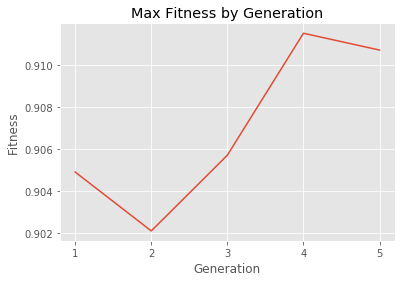

In [10]:
# View how max fitness changed through generations - tier
pp.plot([x + 1 for x in range(5)],[max(x) for x in fitnesses_testtier])
pp.xlabel('Generation')
pp.xticks([x + 1 for x in range(5)])
pp.ylabel('Fitness')
pp.title('Max Fitness by Generation')
pp.show()

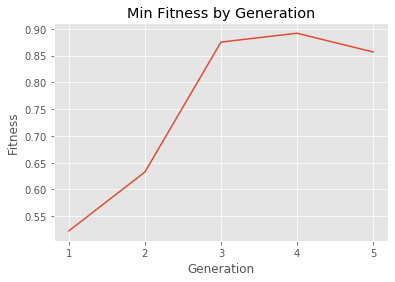

In [11]:
# View how mean fitness changed through generations - tier
pp.plot([x + 1 for x in range(5)],[np.mean(x) for x in fitnesses_testtier])
pp.xlabel('Generation')
pp.xticks([x + 1 for x in range(5)])
pp.ylabel('Fitness')
pp.title('Min Fitness by Generation')
pp.show()

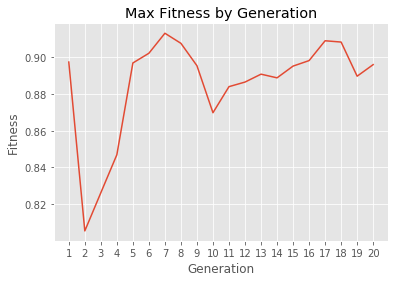

In [7]:
# View how max fitness changed through generations - prob
pp.plot([x + 1 for x in range(20)],[max(x) for x in fitnesses_testprob])
pp.xlabel('Generation')
pp.xticks([x + 1 for x in range(20)])
pp.ylabel('Fitness')
pp.title('Max Fitness by Generation')
pp.show()

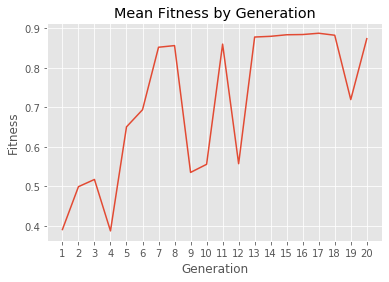

In [8]:
# View how mean fitness changed through generations - prob
pp.plot([x + 1 for x in range(20)],[np.mean(x) for x in fitnesses_testprob])
pp.xlabel('Generation')
pp.xticks([x + 1 for x in range(20)])
pp.ylabel('Fitness')
pp.title('Mean Fitness by Generation')
pp.show()

In [16]:
# Identify correlation coefficient of max fitness through generations - tier
np.corrcoef([x + 1 for x in range(5)],[max(x) for x in fitnesses_testtier])

array([[1.        , 0.82978827],
       [0.82978827, 1.        ]])

In [17]:
# Identify correlation coefficient of max fitness through generations - prob
np.corrcoef([x + 1 for x in range(20)],[max(x) for x in fitnesses_testprob])

array([[1.        , 0.49444869],
       [0.49444869, 1.        ]])

In [6]:
# Identify hyperparameter values of fittest genome - tier
fittest = populationstier[np.argmax([max(x) for x in fitnesses_testtier])][np.argmax(fitnesses_testtier[np.argmax([max(x) for x in fitnesses_testtier])])]
[params[i][fittest[i]] for i in range(0,len(fittest))] 

[<function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 1000,
 50,
 3,
 6,
 2,
 'lr=0.001)',
 'valid',
 'tf.keras.optimizers.RMSprop(',
 100,
 10]

In [7]:
fittest

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]

In [7]:
# Identify hyperparameter values of fittest genome - prob
fittest = populationsprob[np.argmax([max(x) for x in fitnesses_testprob])][np.argmax(fitnesses_testprob[np.argmax([max(x) for x in fitnesses_testprob])])]
[params[i][fittest[i]] for i in range(0,len(fittest))] 

[<function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 100,
 50,
 3,
 2,
 2,
 'lr=0.001)',
 'valid',
 'tf.keras.optimizers.Adam(',
 10,
 10]